# Ocean heat transport in CMIP5 models



## Read data

In [2]:
import matplotlib.pyplot as plt
import iris
import iris.plot as iplt
import iris.coord_categorisation
import cf_units
import numpy

In [3]:
%matplotlib inline 

In [4]:
infile = '/g/data/ua6/DRSv2/CMIP5/NorESM1-M/rcp85/mon/ocean/r1i1p1/hfbasin/latest/hfbasin_Omon_NorESM1-M_rcp85_r1i1p1_200601-210012.nc'

In [5]:
cube = iris.load_cube(infile)

/g/data/r87/dbi599/miniconda3/envs/ocean/lib/python3.6/site-packages/iris/fileformats/cf.py:1143: IrisDeprecation: NetCDF default loading behaviour currently does not expose variables which define reference surfaces for dimensionless vertical coordinates as independent Cubes. This behaviour is deprecated in favour of automatic promotion to Cubes. To switch to the new behaviour, set iris.FUTURE.netcdf_promote to True.
  warn_deprecated(msg)


In [6]:
print(cube)

northward_ocean_heat_transport / (W) (time: 1140; -- : 3; latitude: 166)
     Dimension coordinates:
          time                            x          -            -
          latitude                        -          -            x
     Auxiliary coordinates:
          region                          -          x            -
     Attributes:
          Conventions: CF-1.4
          associated_files: baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation gridspecFile: g...
          branch_time: 56940.0
          cmor_version: 2.6.0
          contact: Please send any requests or bug reports to noresm-ncc@met.no.
          creation_date: 2011-05-28T20:59:53Z
          experiment: RCP8.5
          experiment_id: rcp85
          forcing: GHG, SA, Oz, Sl, BC, OC
          frequency: mon
          history: 2011-05-28T20:59:53Z altered by CMOR: replaced missing value flag (1e+20)...
          initialization_method: 1
          institute_id: NCC
          institution: Norwegian Climate Ce

In [7]:
dim_coord_names = [coord.name() for coord in cube.dim_coords]
print(dim_coord_names)

['time', 'latitude']


In [33]:
cube.coord('latitude').points

array([-80., -79., -78., -77., -76., -75., -74., -73., -72., -71., -70.,
       -69., -68., -67., -66., -65., -64., -63., -62., -61., -60., -59.,
       -58., -57., -56., -55., -54., -53., -52., -51., -50., -49., -48.,
       -47., -46., -45., -44., -43., -42., -41., -40., -39., -38., -37.,
       -36., -35., -34., -33., -32., -31., -30., -29., -28., -27., -26.,
       -25., -24., -23., -22., -21., -20., -19., -18., -17., -16., -15.,
       -14., -13., -12., -11., -10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,
        -3.,  -2.,  -1.,   0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,
         8.,   9.,  10.,  11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,
        19.,  20.,  21.,  22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,
        30.,  31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,
        41.,  42.,  43.,  44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,
        52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,
        63.,  64.,  65.,  66.,  67.,  68.,  69.,  7

In [8]:
aux_coord_names = [coord.name() for coord in cube.aux_coords]
print(aux_coord_names)

['region']


In [9]:
cube.coord('region')

AuxCoord(array(['atlantic_arctic_ocean', 'indian_pacific_ocean', 'global_ocean'], 
      dtype='<U200'), standard_name='region', units=Unit('1'), long_name='ocean basin', var_name='region')

In [10]:
global_cube = cube.extract(iris.Constraint(region='global_ocean'))

In [12]:
def convert_to_annual(cube):
    """Convert data to annual timescale.
    Args:
      cube (iris.cube.Cube)
      full_months(bool): only include years with data for all 12 months
    """

    iris.coord_categorisation.add_year(cube, 'time')
    iris.coord_categorisation.add_month(cube, 'time')

    cube = cube.aggregated_by(['year'], iris.analysis.MEAN)
    cube.remove_coord('year')
    cube.remove_coord('month')

    return cube

In [13]:
global_cube_annual = convert_to_annual(global_cube)

/g/data/r87/dbi599/miniconda3/envs/ocean/lib/python3.6/site-packages/iris/coords.py:495: VisibleDeprecationWarning: an index can only have a single Ellipsis (`...`); replace all but one with slices (`:`).
  bounds = bounds[keys + (Ellipsis, )]


In [14]:
print(global_cube_annual)

northward_ocean_heat_transport / (W) (time: 95; latitude: 166)
     Dimension coordinates:
          time                            x             -
          latitude                        -             x
     Scalar coordinates:
          region: global_ocean
     Attributes:
          Conventions: CF-1.4
          associated_files: baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation gridspecFile: g...
          branch_time: 56940.0
          cmor_version: 2.6.0
          contact: Please send any requests or bug reports to noresm-ncc@met.no.
          creation_date: 2011-05-28T20:59:53Z
          experiment: RCP8.5
          experiment_id: rcp85
          forcing: GHG, SA, Oz, Sl, BC, OC
          frequency: mon
          history: 2011-05-28T20:59:53Z altered by CMOR: replaced missing value flag (1e+20)...
          initialization_method: 1
          institute_id: NCC
          institution: Norwegian Climate Centre
          model_id: NorESM1-M
          modeling_realm: ocean
   

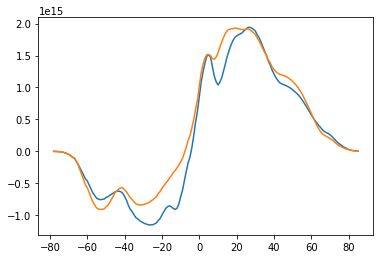

In [15]:
iplt.plot(global_cube_annual[5, ::])
iplt.plot(global_cube_annual[20, ::])
plt.show()

So for any given year, the annual mean shows ocean heat transport away from the tropics.

## Trends

In [17]:
def convert_to_seconds(time_axis):
    """Convert time axis units to seconds.
    
    Args:
      time_axis(iris.DimCoord)
    
    """

    old_units = str(time_axis.units)
    old_timestep = old_units.split(' ')[0]
    new_units = old_units.replace(old_timestep, 'seconds') 

    new_unit = cf_units.Unit(new_units, calendar=time_axis.units.calendar)  
    time_axis.convert_units(new_unit)

    return time_axis


def linear_trend(data, time_axis):
    """Calculate the linear trend.
    
    polyfit returns [a, b] corresponding to y = a + bx

    """    

    masked_flag = False

    if type(data) == numpy.ma.core.MaskedArray:
        if type(data.mask) == numpy.bool_:
            if data.mask:
                masked_flag = True
        elif data.mask[0]:
            masked_flag = True
            
    if masked_flag:
        return data.fill_value
    else:
        return numpy.polynomial.polynomial.polyfit(time_axis, data, 1)[-1]


def calc_trend(cube):
    """Calculate linear trend.
    Args:
      cube (iris.cube.Cube)
      running_mean(bool, optional): 
        A 12-month running mean can first be applied to the data
      yr (bool, optional):
        Change units from per second to per year
    """

    time_axis = cube.coord('time')
    time_axis = convert_to_seconds(time_axis)

    trend = numpy.ma.apply_along_axis(linear_trend, 0, cube.data, time_axis.points)
    trend = numpy.ma.masked_values(trend, cube.data.fill_value)

    return trend

In [18]:
trend_data = calc_trend(global_cube_annual)

trend_cube = global_cube_annual[0, ::].copy()
trend_cube.data = trend_data
trend_cube.remove_coord('time')

#trend_unit = ' yr-1'
#trend_cube.units = str(global_cube_annual.units) + trend_unit

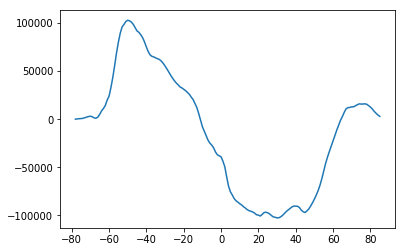

In [19]:
iplt.plot(trend_cube)
plt.show()

So the trends in ocean heat transport suggest reduced transport in the RCP 8.5 simulation (i.e. the trend plot is almost the inverse of the climatology plot).

## Convergence

In [20]:
print(global_cube_annual)

northward_ocean_heat_transport / (W) (time: 95; latitude: 166)
     Dimension coordinates:
          time                            x             -
          latitude                        -             x
     Scalar coordinates:
          region: global_ocean
     Attributes:
          Conventions: CF-1.4
          associated_files: baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation gridspecFile: g...
          branch_time: 56940.0
          cmor_version: 2.6.0
          contact: Please send any requests or bug reports to noresm-ncc@met.no.
          creation_date: 2011-05-28T20:59:53Z
          experiment: RCP8.5
          experiment_id: rcp85
          forcing: GHG, SA, Oz, Sl, BC, OC
          frequency: mon
          history: 2011-05-28T20:59:53Z altered by CMOR: replaced missing value flag (1e+20)...
          initialization_method: 1
          institute_id: NCC
          institution: Norwegian Climate Centre
          model_id: NorESM1-M
          modeling_realm: ocean
   

In [21]:
diffs_data = numpy.diff(global_cube_annual.data, axis=1)
lats = global_cube_annual.coord('latitude').points
diffs_lats = (lats[1:] + lats[:-1]) / 2.

In [22]:
print(diffs_data.shape)
print(len(diffs_lats))

(95, 165)
165


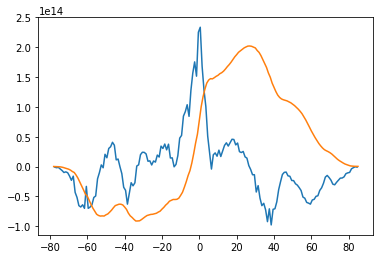

In [24]:
plt.plot(diffs_lats, diffs_data[0, :])
plt.plot(lats, global_cube_annual[0, ::].data / 10.0)
plt.show()

## Convergence trend

In [26]:
time_axis = global_cube_annual.coord('time')
time_axis = convert_to_seconds(time_axis)

diffs_trend = numpy.ma.apply_along_axis(linear_trend, 0, diffs_data, time_axis.points)
diffs_trend = numpy.ma.masked_values(diffs_trend, global_cube_annual.data.fill_value)

In [27]:
print(diffs_trend.shape)

(165,)


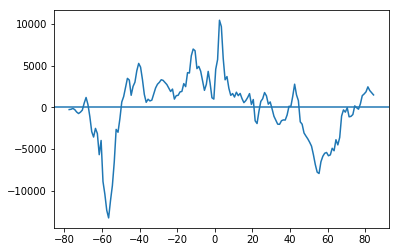

In [28]:
plt.plot(diffs_lats, diffs_trend * -1)
plt.axhline(y=0)
plt.show()

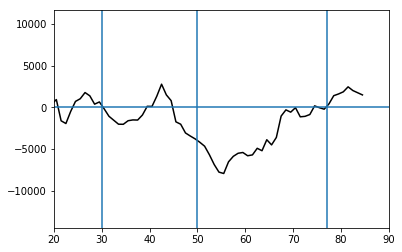

In [32]:
plt.plot(diffs_lats, diffs_trend * -1, color='black')
plt.axhline(y=0)
plt.axvline(x=30)
plt.axvline(x=50)
plt.axvline(x=77)
plt.xlim(20, 90)
plt.show()

When I try and replicate the HTC curve in Figure 1 of [Nummelin et al (2016)](http://onlinelibrary.wiley.com/doi/10.1002/2016GL071333/abstract;jsessionid=7BC4C1DF16F35341AE3D3689F363955B.f02t01) (above) it looks different because I've plotted $W s^{-1}$, whereas they plot $W m^{-2}$. So I need to divide by area and mutliply by their delta $\delta t/2$ (i.e. ($60 \times 60 \times 24 \times 365.25 \times 95) / 2$). 

FIXME: Probably easiest to re-do this NorESM1-M analysis with hfy.

Once I've done that to confirm that I can reproduce their results, I may actually want to stick with $W s^{-1}$. Dividing by area inflates the high latitude regions, whereas I'm more interested in where the big heat transports are taking place.